# **Basic Skeleton Version 3**
# Target:
#### Update each layer with **Batch Normalization** in each convolution block (except the last layer) to normalize kernel outputs and improve convergence.
### Results:

* Parameters: 5,893
* Best Train Accuracy: 99.30%
* Best Test Accuracy: 99.12%

**Analysis:**
- Model is having parameters less than 8000 parameters.
- Batch Normalization improved convergence and increased accuracies.  
- Slight overfitting was observed.  
- Further updates with Step LR Schedulers in the next version.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations



In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.88MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders



In [4]:
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# The Model Architecture


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # INPUT BLOCK
        # First convolution layer to process input image
        # Input: 28x28x1 | Output: 26x26x7
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=7, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),  # Activation function
            nn.BatchNorm2d(num_features=7)  # Normalize the features
        )

        # CONVOLUTION BLOCK 1
        # Increase feature maps and reduce spatial dimensions
        # Input: 26x26x7 | Output: 24x24x14
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=14)
        )

        # First pooling layer to reduce spatial dimensions
        # Input: 24x24x14 | Output: 12x12x14
        self.pool1 = nn.MaxPool2d(2, 2)

        # Reduce channels while maintaining spatial information
        # Input: 12x12x14 | Output: 10x10x7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=7, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=7)
        )

        # TRANSITION BLOCK 1
        # Note: pool1 is defined twice - this might be a bug in the original code
        # Second pooling operation
        # Input: 10x10x7 | Output: 5x5x7
        self.pool1 = nn.MaxPool2d(2, 2)

        # 1x1 convolution to increase channels without affecting spatial dimensions
        # Input: 5x5x7 | Output: 5x5x14
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=14, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=14)
        )

        # CONVOLUTION BLOCK 2
        # Further feature extraction with increased channels
        # Input: 5x5x14 | Output: 3x3x28
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=28, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=28)
        )

        # OUTPUT BLOCK
        # 1x1 convolution to reduce channels to match number of classes
        # Input: 3x3x28 | Output: 3x3x10
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=10)
        )

        # Global average pooling to reduce spatial dimensions
        # Input: 3x3x10 | Output: 1x1x10
        self.convblock7 = nn.Sequential(
            nn.AvgPool2d(kernel_size=(3,3))
        )

    def forward(self, x):
        # Forward pass through the network
        x = self.convblock1(x)  # Initial feature extraction
        x = self.convblock2(x)  # Increase feature maps
        x = self.pool1(x)       # Reduce spatial dimensions
        x = self.convblock3(x)  # Channel reduction
        x = self.pool1(x)       # Further spatial reduction
        x = self.convblock4(x)  # Channel increase with 1x1 conv
        x = self.convblock5(x)  # Deep feature extraction
        x = self.convblock6(x)  # Reduce to number of classes
        x = self.convblock7(x)  # Global average pooling
        x = x.view(-1, 10)      # Flatten to (batch_size, num_classes)
        return F.log_softmax(x, dim=-1)  # Apply log softmax for classification

# Model Params

In [6]:
!pip install torchsummary

In [7]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 26, 26]              63
              ReLU-2            [-1, 7, 26, 26]               0
       BatchNorm2d-3            [-1, 7, 26, 26]              14
            Conv2d-4           [-1, 14, 24, 24]             882
              ReLU-5           [-1, 14, 24, 24]               0
       BatchNorm2d-6           [-1, 14, 24, 24]              28
         MaxPool2d-7           [-1, 14, 12, 12]               0
            Conv2d-8            [-1, 7, 10, 10]             882
              ReLU-9            [-1, 7, 10, 10]               0
      BatchNorm2d-10            [-1, 7, 10, 10]              14
        MaxPool2d-11              [-1, 7, 5, 5]               0
           Conv2d-12             [-1, 14, 5, 5]              98
             ReLU-13             [-1, 14, 5, 5]               0
      BatchNorm2d-14             [

# Training and Testing

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model


In [9]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.14009959995746613 Batch_id=468 Accuracy=92.43: 100%|██████████| 469/469 [00:38<00:00, 12.32it/s]



Test set: Average loss: 0.1183, Accuracy: 9772/10000 (97.72%)

EPOCH: 1


Loss=0.08455339074134827 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:30<00:00, 15.29it/s]



Test set: Average loss: 0.0799, Accuracy: 9830/10000 (98.30%)

EPOCH: 2


Loss=0.04222959652543068 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:30<00:00, 15.14it/s]



Test set: Average loss: 0.0626, Accuracy: 9853/10000 (98.53%)

EPOCH: 3


Loss=0.06675305962562561 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:30<00:00, 15.28it/s]



Test set: Average loss: 0.0509, Accuracy: 9876/10000 (98.76%)

EPOCH: 4


Loss=0.03072110004723072 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:32<00:00, 14.52it/s]



Test set: Average loss: 0.0465, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.01076709758490324 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:31<00:00, 15.12it/s]



Test set: Average loss: 0.0412, Accuracy: 9889/10000 (98.89%)

EPOCH: 6


Loss=0.03179677203297615 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:30<00:00, 15.19it/s]



Test set: Average loss: 0.0354, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.027477456256747246 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:31<00:00, 15.00it/s]



Test set: Average loss: 0.0367, Accuracy: 9905/10000 (99.05%)

EPOCH: 8


Loss=0.006429012399166822 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:31<00:00, 15.07it/s]



Test set: Average loss: 0.0352, Accuracy: 9906/10000 (99.06%)

EPOCH: 9


Loss=0.017331315204501152 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]



Test set: Average loss: 0.0384, Accuracy: 9896/10000 (98.96%)

EPOCH: 10


Loss=0.056140486150979996 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:30<00:00, 15.28it/s]



Test set: Average loss: 0.0367, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.0219904612749815 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:30<00:00, 15.29it/s]



Test set: Average loss: 0.0328, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.05168340727686882 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:30<00:00, 15.24it/s]



Test set: Average loss: 0.0332, Accuracy: 9907/10000 (99.07%)

EPOCH: 13


Loss=0.022269537672400475 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:30<00:00, 15.36it/s]



Test set: Average loss: 0.0327, Accuracy: 9908/10000 (99.08%)

EPOCH: 14


Loss=0.028538508340716362 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:31<00:00, 14.82it/s]



Test set: Average loss: 0.0295, Accuracy: 9912/10000 (99.12%)



Text(0.5, 1.0, 'Test Accuracy')

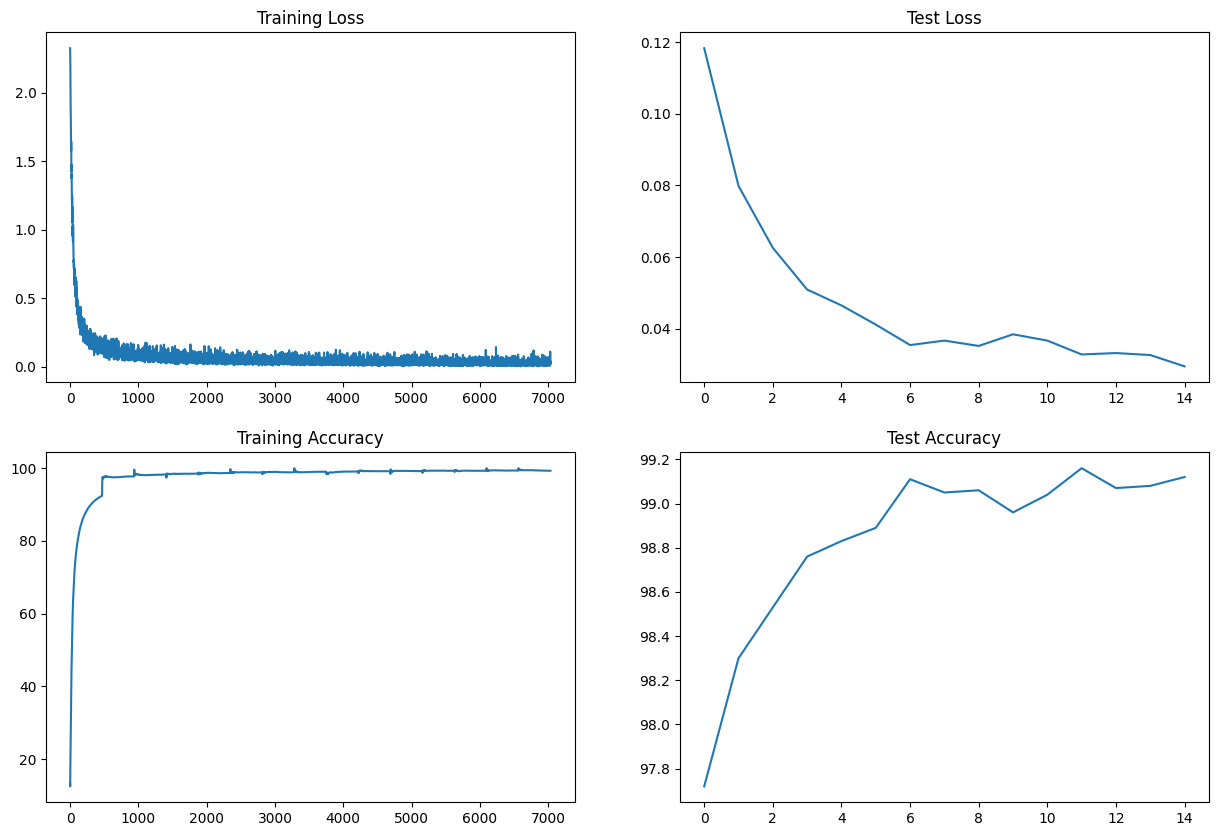

In [11]:
# Commented out IPython magic to ensure Python compatibility.
t = [t_items.item() for t_items in train_losses]
# %matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")